In [1]:
from pprint import  pprint
import itertools

import torch
from torch import nn
import torchvision
import presets
import numpy as np
import calibration_utils

from torchvision.transforms.functional import InterpolationMode

from sklearn.metrics import  confusion_matrix

from matplotlib import pyplot as plt

device = 'cpu'
MODEL = 'mobilenet_v3_large'
NUM_CLASSES = 2
PATH = 'output/model_9.pth'

In [2]:
model = torchvision.models.get_model(MODEL, weights=None, num_classes=NUM_CLASSES)
state_dict = torch.load(PATH)
model.load_state_dict(state_dict['model'])
model.to(device)
None

FileNotFoundError: [Errno 2] No such file or directory: 'output/model_9.pth'

In [ ]:
args = state_dict["args"]
valdir = "data/val"
interpolation = InterpolationMode(args.interpolation)

In [ ]:
preprocessing = presets.ClassificationPresetEval(
                crop_size=args.val_crop_size,
                resize_size=args.val_resize_size,
                interpolation=interpolation,
                backend=args.backend,
                use_v2=args.use_v2,
            )

dataset_test = torchvision.datasets.ImageFolder(
    valdir,
    preprocessing,
)
test_sampler = torch.utils.data.SequentialSampler(dataset_test)
data_loader = torch.utils.data.DataLoader(
        dataset_test, batch_size=args.batch_size, sampler=test_sampler, num_workers=args.workers, pin_memory=True
    )

In [ ]:
criterion = nn.CrossEntropyLoss()

conf_scores, preds, gt = list(), list(), list()
with torch.inference_mode():
    for image, target in data_loader:
        image = image.to(device, non_blocking=True)
        target = target.to(device, non_blocking=True)
        output = model(image)
        # loss = criterion(output, target)
        conf_scores.append(torch.nn.functional.softmax(output, dim=1))
        preds.append(torch.argmax(output, dim=1))
        gt.append(target)

In [ ]:

np_gt = np.concatenate([x.numpy() for x in gt])
np_pred = np.concatenate([x.numpy() for x in preds])
np_conf = np.concatenate([x[:,0].numpy() for x in conf_scores])

In [ ]:
# calibration_utils.plot_confusion_matrix(confusion_matrix(np_gt, np_pred), ["benign", "malignant"])
pprint(confusion_matrix(np_gt, np_pred))

NameError: name 'pprint' is not defined

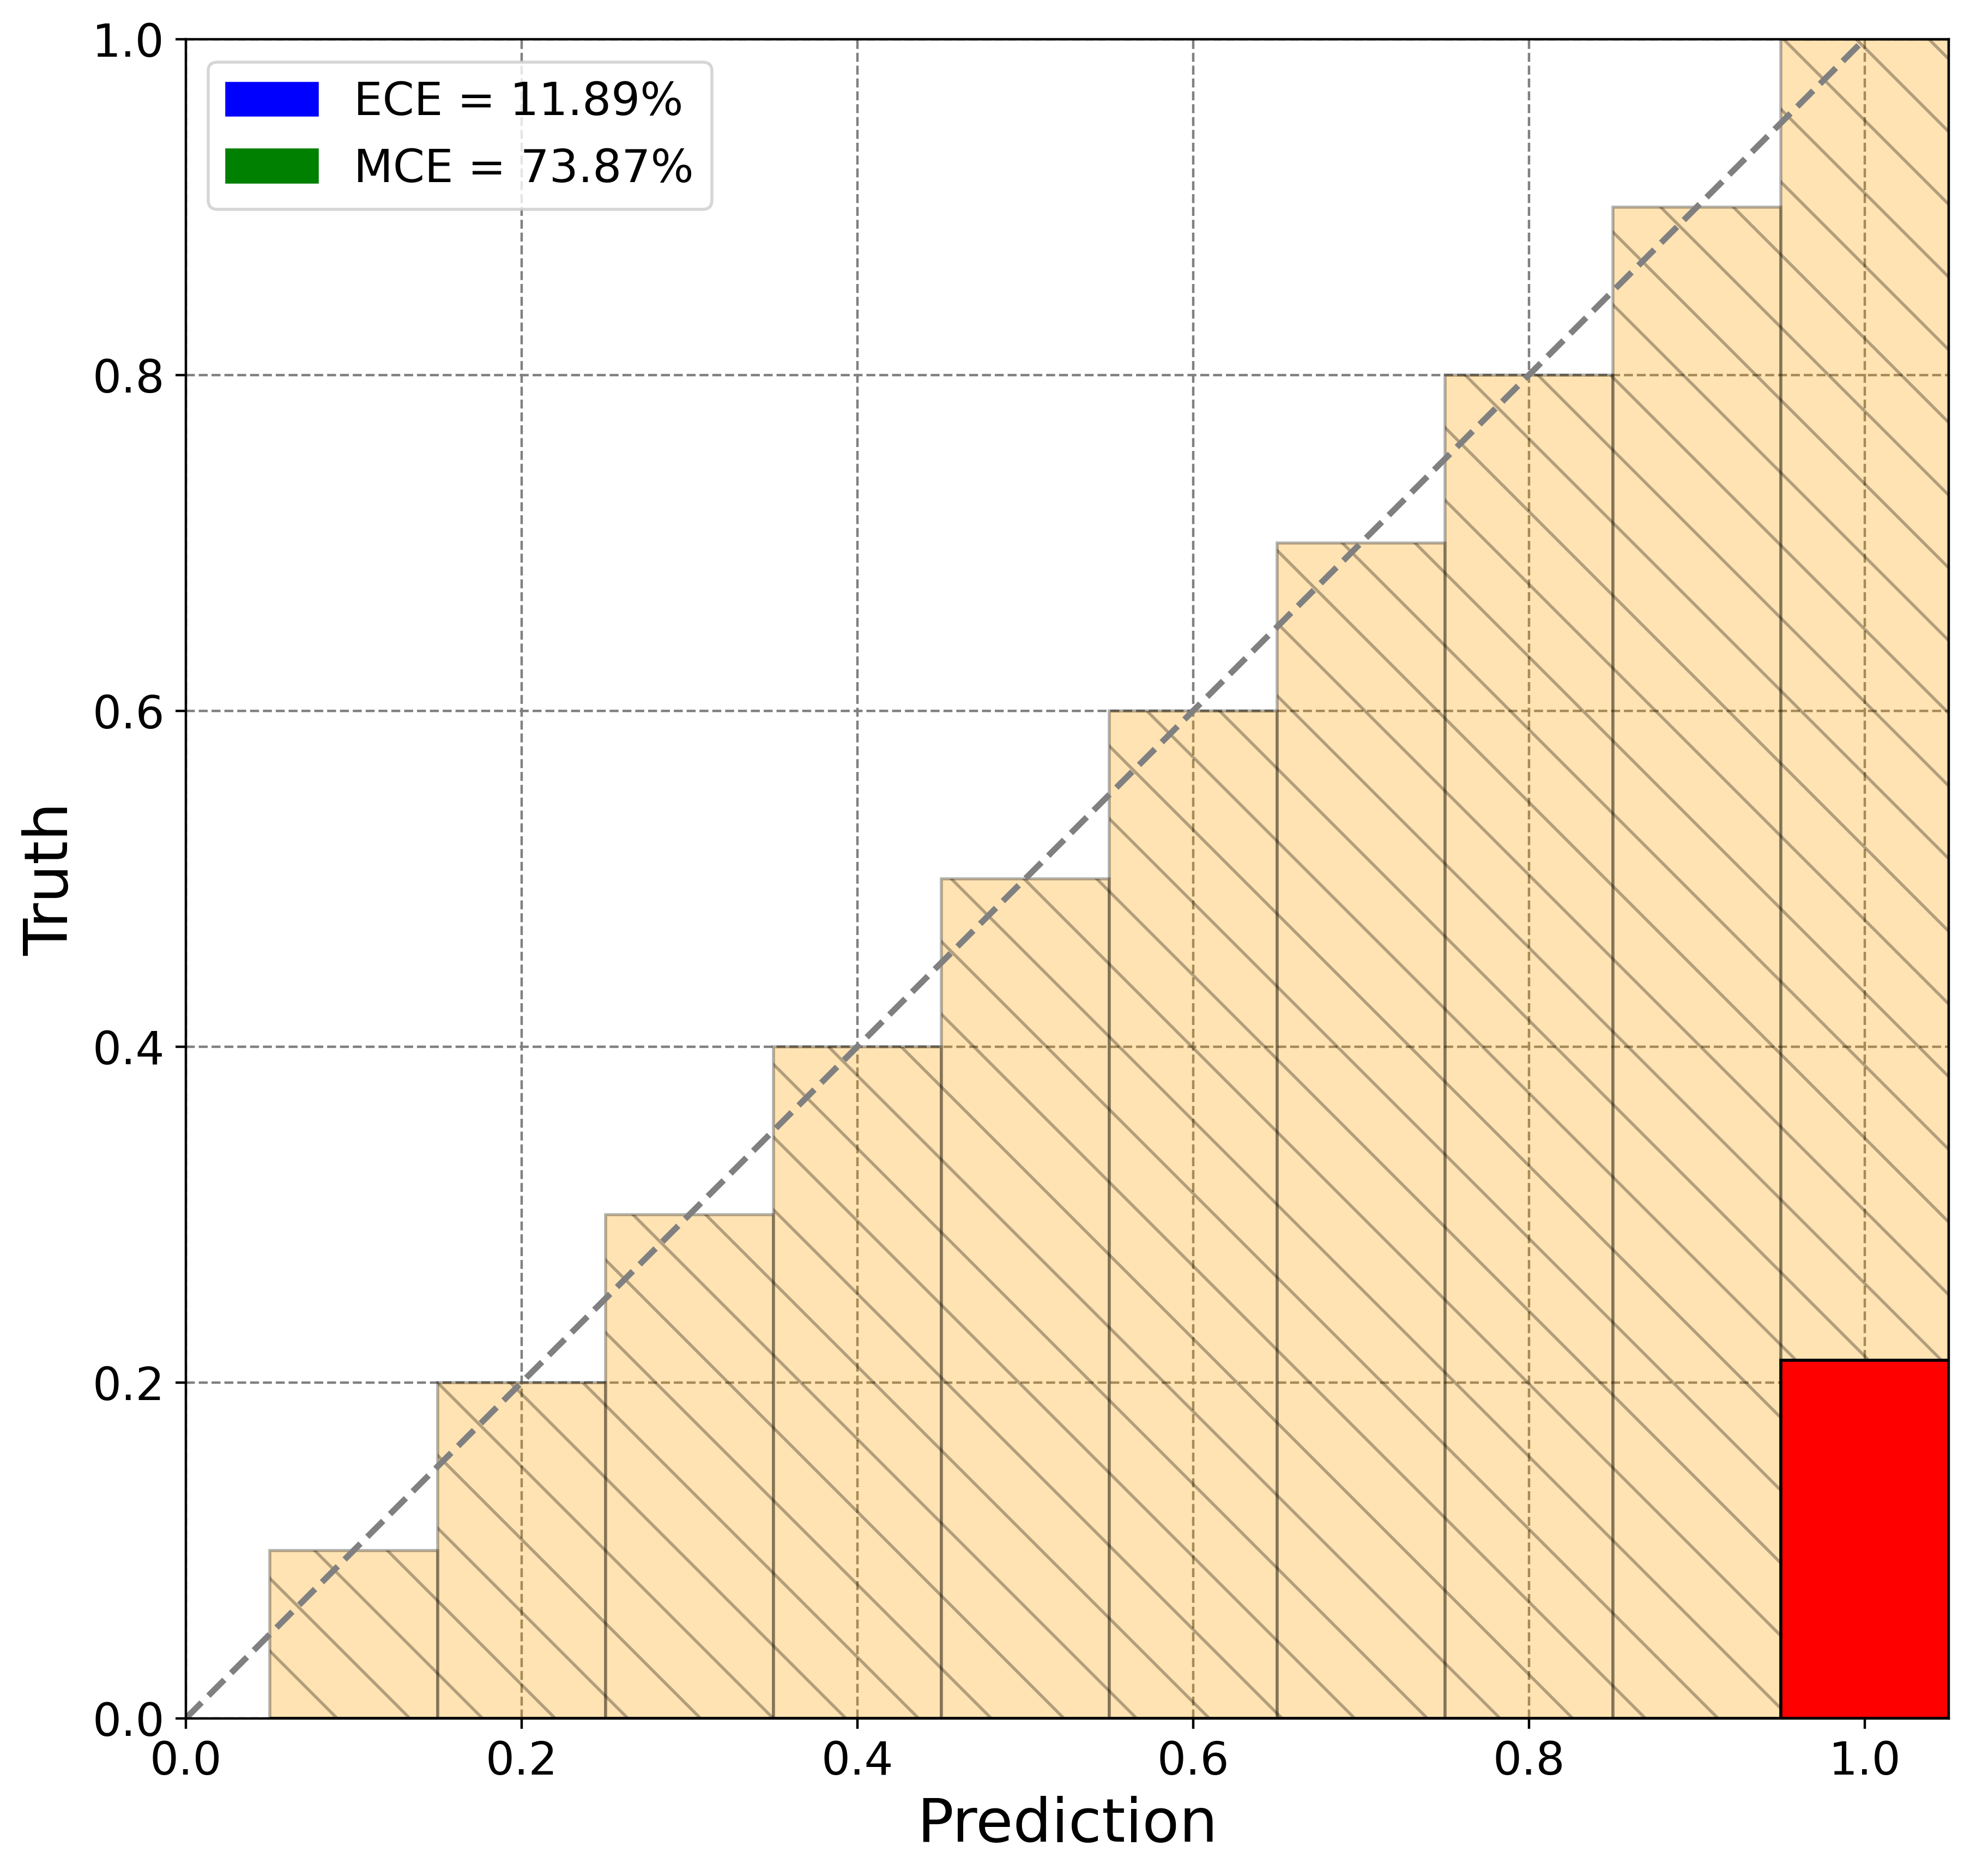

In [ ]:
# calibration_utils.draw_reliability_graph(np_gt, np_conf)

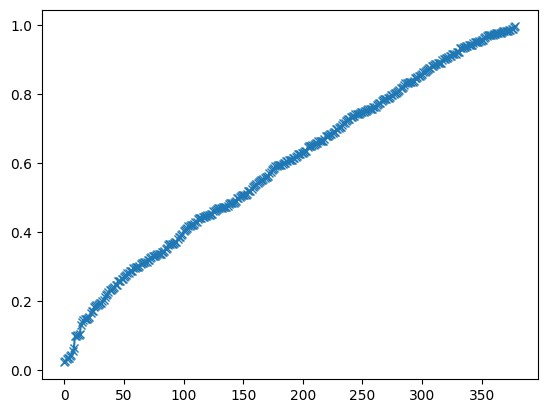

In [ ]:
# conf_sort = np.sort(np_conf)
# plt.plot(conf_sort, marker='x')
# plt.show()
# plt.close()

In [ ]:
metrics = calibration_utils.matrix_metrix(np_gt, np_pred, 1.0)

In [ ]:
pprint(metrics)

        Metric       Value
0           TP   30.000000
1           TN  187.000000
2           FP  117.000000
3           FN   45.000000
4   Prevalence    0.390000
5     Accuracy    0.572600
6    Precision    0.204100
7          NPV    0.806000
8          FDR    0.795900
9          FOR    0.194000
10   check_Pos    1.000000
11   check_Neg    1.000000
12      Recall    0.400000
13         FPR    0.384900
14         FNR    0.600000
15         TNR    0.615100
16  check_Pos2    1.000000
17  check_Neg2    1.000000
18         LR+    1.039200
19         LR-    0.975500
20         DOR    1.000000
21          F1    0.270300
22       FBeta    0.270300
23         MCC    0.012400
24          BM    0.015100
25          MK    0.010100
26       Kappa    0.011113
